In [83]:
from FORM import FORM, PROP
from cnf_io import read_cnf_file
from variable import reset_calls, increment_calls, value_calls
from sat_solver import naive_solve, tree_solve_random, tree_solve
import matplotlib.pyplot as plt
import random
import time
import csv
import pandas as pd
import numpy as np
import func_timeout
import os


create code to randomly generate cnf clauses in file

In [6]:
def create_cnf(prop_num, clause_num, file_name):
  """Creates a CNF file with the given number of variables and clauses.

  Args:
    prop_num: The number of variables in the CNF file.
    clause_num: The number of clauses in the CNF file.
    file_name: The name of the CNF file to create.
  """

  # Create the folder if it doesn't exist
  folder_path = os.path.dirname(file_name)
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

  # Create the CNF file
  with open(file_name, "w") as f:
    # Write the problem line in the DIMACS format
    f.write(f"p cnf {prop_num} {clause_num}\n")

    # Add random clauses
    for i in range(clause_num):
      clause = [random.randint(-prop_num, prop_num) for _ in range(3)]

      # Check for zeros and replace with non-zeros
      for j in range(3):
        if clause[j] == 0:
          clause[j] = 1 if random.random() < 0.5 else -1

      # Add clause to file
      f.write(" ".join(map(str, clause)) + " 0\n")


In [13]:
create_cnf(50,50,'Experiment/example_1_file.cnf')
print(read_cnf_file('Experiment/example_1_file.cnf'))

((x_37 v x_47 v x_37) ^ ((-x_26) v (-x_15) v x_50) ^ ((-x_5) v x_18 v x_39) ^ (x_45 v x_9 v (-x_33)) ^ ((-x_43) v (-x_34) v x_39) ^ ((-x_13) v (-x_24) v x_44) ^ ((-x_1) v x_1 v (-x_38)) ^ ((-x_7) v x_40 v x_27) ^ (x_23 v (-x_39) v (-x_15)) ^ ((-x_13) v (-x_20) v (-x_17)) ^ (x_45 v (-x_50) v (-x_50)) ^ ((-x_36) v (-x_38) v x_32) ^ ((-x_31) v (-x_25) v x_18) ^ (x_26 v x_13 v x_4) ^ (x_31 v (-x_39) v x_22) ^ ((-x_33) v (-x_1) v (-x_33)) ^ ((-x_8) v x_24 v (-x_35)) ^ ((-x_43) v x_12 v x_25) ^ (x_8 v (-x_5) v x_40) ^ ((-x_17) v (-x_29) v (-x_5)) ^ ((-x_36) v x_25 v (-x_12)) ^ ((-x_41) v x_5 v x_50) ^ ((-x_39) v x_7 v x_9) ^ ((-x_41) v x_41 v x_13) ^ ((-x_8) v x_12 v (-x_30)) ^ (x_20 v (-x_25) v (-x_21)) ^ (x_49 v (-x_35) v (-x_45)) ^ ((-x_6) v x_11 v x_14) ^ (x_46 v (-x_49) v (-x_40)) ^ ((-x_39) v (-x_39) v x_41) ^ (x_35 v x_12 v x_1) ^ ((-x_29) v (-x_18) v (-x_44)) ^ ((-x_48) v x_5 v x_7) ^ (x_34 v x_42 v (-x_7)) ^ (x_39 v (-x_5) v (-x_9)) ^ ((-x_40) v (-x_4) v x_49) ^ (x_41 v x_30 v x_35)

Create function that prints tuple of information to csv_file

In [15]:
def output_tuple_to_csv(tuple, csv_file_name):
  """Outputs a tuple to a CSV file, creating the file and folder if necessary.

  Args:
    tuple: A tuple of strings to be output to the CSV file.
    csv_file_name: The name of the CSV file to output to.
  """

  # Create the folder if it doesn't exist
  folder_path = os.path.dirname(csv_file_name)
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

  # Create the CSV file if it doesn't exist
  if not os.path.exists(csv_file_name):
    with open(csv_file_name, "w", newline="") as f:
      writer = csv.writer(f)

  # Open the CSV file in append mode
  with open(csv_file_name, "a", newline="") as f:
    writer = csv.writer(f)

    # Write the tuple to the CSV file
    writer.writerow(tuple)

run an experiment that compares the different heuristics over differing numbers of clauses and propositions. Experiment will initially be run for 3-cnf formulas and be saved to text files to keep the data safe while it is running.

 Note that the experiment self corrects when it runs a formula which runs too long. If a formula takes too long to solve the next formula will have fewer propositions and if the formula was solved in an appropriate amount of time then the code will solve a slightly larger formula.

Do Not run this code with large values. It just demonstrates how the experiment was run.

In [25]:
prop_original = 40
test_num = 1
prop_num = prop_original
clause_num = int(prop_num * 3)
formula_file_name = f"Experiment/formulas/cnf_3_testing.cnf"
data_file_name='Experiment/Data/experiment_testing.csv'
#output_tuple_to_csv(('propositions', 'clauses', 'result','DPLL calls','L/N ratio','solve time'),data_file_name)
for i in range(16):
    print(i)
    LN_ratio = (3+i*0.2)
    j = 0
    while j < test_num:
        clause_num = int(prop_num * LN_ratio)
        create_cnf(prop_num,clause_num,formula_file_name)
        formula = read_cnf_file(formula_file_name) 
        reset_calls()
        start = time.time()       
        try:
            solution = func_timeout.func_timeout(30, tree_solve, [formula, {"unit_preference": False, "two_clause": False, "polarity": False}])
        except TimeoutError:
            prop_num -= 5
            clause_num = int(prop_num * LN_ratio)
            continue
        if solution != 'UNSAT' and not(formula.evaluate(solution)):
            output_tuple_to_csv(('****WRONG****'),data_file_name)
        else:
            end = time.time()
            calls = value_calls()
            elapsed_time = end - start
            output_tuple_to_csv((prop_num,clause_num, formula.evaluate(solution), calls, LN_ratio ,elapsed_time),data_file_name)
            prop_num += 2
            j += 1
            clause_num = int(prop_num * LN_ratio)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Now create the pandas dataframes for analyzing the date

In [77]:
df_random = pd.read_csv('Experiment/Data/experiment_random.csv')
df_two_clause = pd.read_csv('Experiment/Data/experiment_two_clause.csv')
df_polarity = pd.read_csv('Experiment/Data/experiment_polarity.csv', names=['propositions', 'clauses', 'result','DPLL calls','L/N ratio','solve time'])

In [78]:
df_two_clause

,propositions,clauses,result,DPLL calls,L/N ratio,solve time
0,50,150,True,55,3.0,0.052575
1,53,159,True,123,3.0,0.070844
2,56,168,True,56,3.0,0.034089
3,59,177,True,58,3.0,0.073359
4,62,186,True,80,3.0,0.047482
...,...,...,...,...,...,...
1610,80,240,True,110,3.0,0.115173
1611,83,249,True,91,3.0,0.106636
1612,86,258,True,94,3.0,0.114773
1613,89,267,True,81,3.0,0.107916


Clean data from ridiculous datapoints(sat solver timed out at max 100s so data above that is ridiculous thousands)

In [68]:
df_random = df_random[df_random['solve time'] < 100]

Evaluate performance of random and polarity heuristic on random formulae

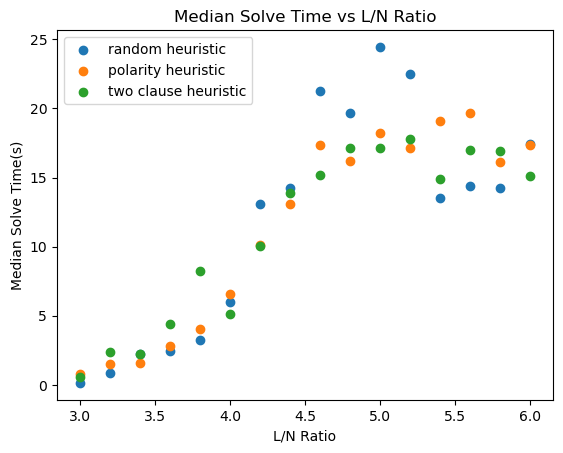

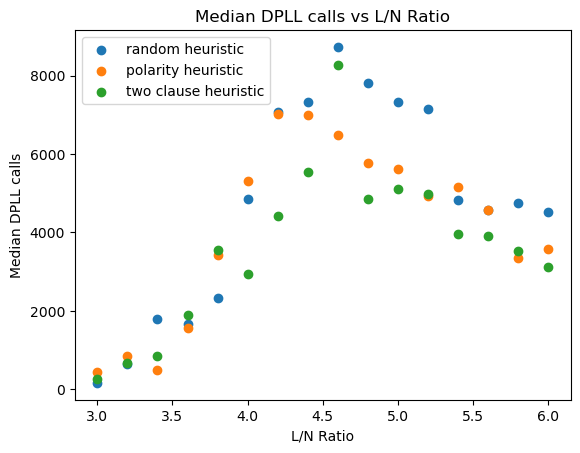

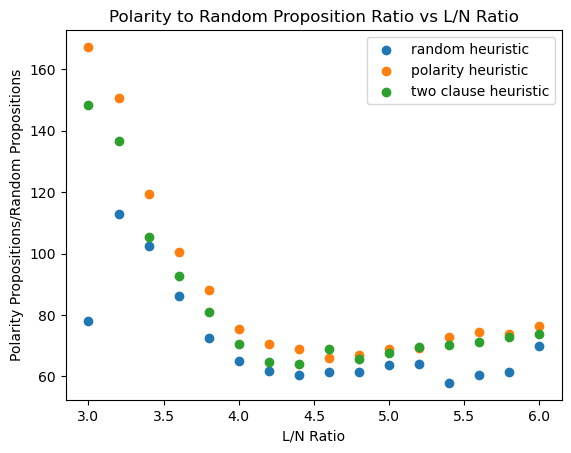

In [98]:
df_two_clause_sample = df_two_clause
df_two_clause_grouped = df_two_clause_sample.groupby('L/N ratio')
df_two_clause_time = df_two_clause_grouped['solve time'].median()
df_two_clause_calls = df_two_clause_grouped['DPLL calls'].median()
df_two_clause_props = df_two_clause_grouped['propositions'].mean()
calls_two_clause = []
time_two_clause = []

df_random_sample = df_random
df_polarity_sample = df_polarity
df_random_grouped = df_random_sample.groupby('L/N ratio')
df_polarity_grouped = df_polarity_sample.groupby('L/N ratio')
df_random_calls = df_random_grouped['DPLL calls'].median()
df_polarity_calls = df_polarity_grouped['DPLL calls'].median()
df_random_time = df_random_grouped['solve time'].median()
df_polarity_time = df_polarity_grouped['solve time'].median()
df_random_props = df_random_grouped['propositions'].mean()
df_polarity_props = df_polarity_grouped['propositions'].mean()
LN_ratios = []
prop_polarity = []
prop_two_clause = []
prop_random = []
calls_random = []
calls_polarity = []
time_random = []
time_polarity = []
for i in range(16):
    LN_ratio = i*0.2 + 3
    LN_ratios.append(LN_ratio)
    calls_random.append(df_random_calls[LN_ratio])
    calls_polarity.append(df_polarity_calls[LN_ratio])
    time_random.append(df_random_time[LN_ratio])
    time_polarity.append(df_polarity_time[LN_ratio])
    prop_polarity.append(df_polarity_props[LN_ratio])
    prop_random.append(df_random_props[LN_ratio])
    calls_two_clause.append(df_two_clause_calls[LN_ratio])
    time_two_clause.append(df_two_clause_time[LN_ratio])
    prop_two_clause.append(df_two_clause_props[LN_ratio])
plt.scatter(LN_ratios, time_random, label='random heuristic')
plt.scatter(LN_ratios,time_polarity, label = 'polarity heuristic')
plt.scatter(LN_ratios,time_two_clause, label = 'two clause heuristic')
plt.legend()
plt.xlabel("L/N Ratio")
plt.ylabel("Median Solve Time(s)")
plt.title("Median Solve Time vs L/N Ratio")
plt.show()
plt.scatter(LN_ratios, calls_random, label='random heuristic')
plt.scatter(LN_ratios,calls_polarity, label = 'polarity heuristic')
plt.scatter(LN_ratios,calls_two_clause, label = 'two clause heuristic')
plt.legend()
plt.xlabel("L/N Ratio")
plt.ylabel("Median DPLL calls")
plt.title("Median DPLL calls vs L/N Ratio")
plt.show()
plt.xlabel("L/N Ratio")
plt.ylabel("Polarity Propositions/Random Propositions")
plt.title("Polarity to Random Proposition Ratio vs L/N Ratio")
plt.scatter(LN_ratios,prop_random, label='random heuristic')
plt.scatter(LN_ratios,prop_polarity, label='polarity heuristic')
plt.scatter(LN_ratios,prop_two_clause, label='two clause heuristic')
plt.legend()
plt.show()

Find probability that random SAT function is true given L/N ratio

In [41]:
df_total = pd.concat([df_random,df_two_clause,df_polarity])
df_grouped = df_total.groupby('L/N ratio')
df_prob = df_grouped['result'].value_counts(True)
LN_ratios = []
SAT_probs = []
for i in range(16):
    LN_ratios.append(3+i*0.2)
    SAT_probs.append(df_prob[3+i*0.2][True])

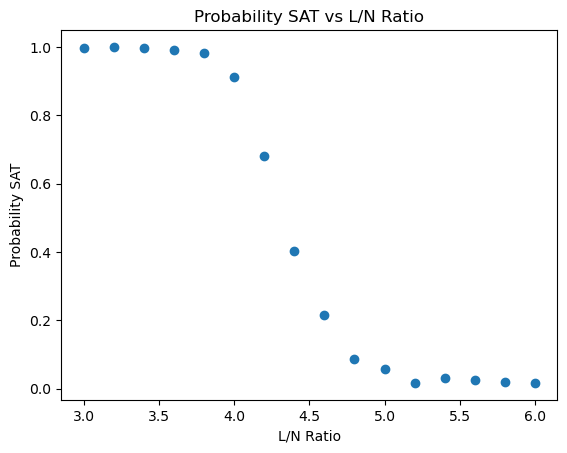

In [45]:
plt.scatter(LN_ratios, SAT_probs)
plt.title("Probability SAT vs L/N Ratio")
plt.xlabel("L/N Ratio")
plt.ylabel("Probability SAT")
plt.show()

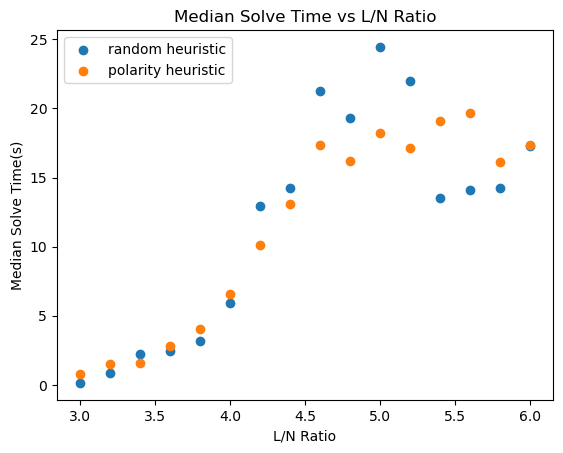

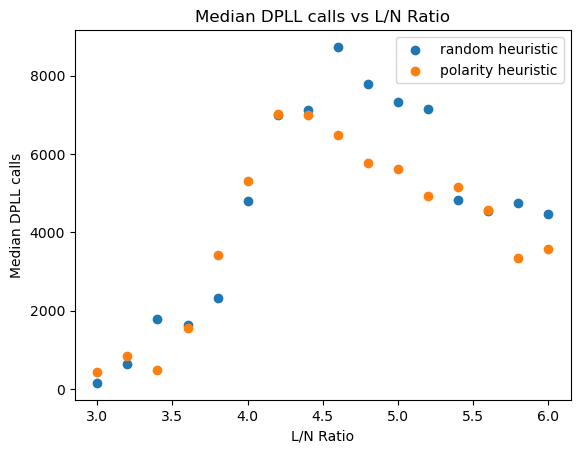

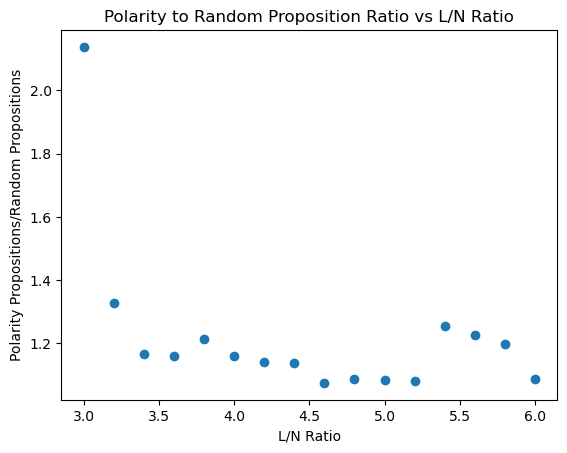

In [74]:
df_random_sample = df_random
df_polarity_sample = df_polarity
df_random_grouped = df_random_sample.groupby('L/N ratio')
df_polarity_grouped = df_polarity_sample.groupby('L/N ratio')
df_random_calls = df_random_grouped['DPLL calls'].median()
df_polarity_calls = df_polarity_grouped['DPLL calls'].median()
df_random_time = df_random_grouped['solve time'].median()
df_polarity_time = df_polarity_grouped['solve time'].median()
df_random_props = df_random_grouped['propositions'].mean()
df_polarity_props = df_polarity_grouped['propositions'].mean()
LN_ratios = []
prop_ratio = []
calls_random = []
calls_polarity = []
time_random = []
time_polarity = []
for i in range(16):
    LN_ratio = i*0.2 + 3
    LN_ratios.append(LN_ratio)
    calls_random.append(df_random_calls[LN_ratio])
    calls_polarity.append(df_polarity_calls[LN_ratio])
    time_random.append(df_random_time[LN_ratio])
    time_polarity.append(df_polarity_time[LN_ratio])
    prop_ratio.append(df_polarity_props[LN_ratio]/df_random_props[LN_ratio])
plt.scatter(LN_ratios, time_random, label='random heuristic')
plt.scatter(LN_ratios,time_polarity, label = 'polarity heuristic')
plt.legend()
plt.xlabel("L/N Ratio")
plt.ylabel("Median Solve Time(s)")
plt.title("Median Solve Time vs L/N Ratio")
plt.show()
plt.scatter(LN_ratios, calls_random, label='random heuristic')
plt.scatter(LN_ratios,calls_polarity, label = 'polarity heuristic')
plt.legend()
plt.xlabel("L/N Ratio")
plt.ylabel("Median DPLL calls")
plt.title("Median DPLL calls vs L/N Ratio")
plt.show()
plt.xlabel("L/N Ratio")
plt.ylabel("Polarity Propositions/Random Propositions")
plt.title("Polarity to Random Proposition Ratio vs L/N Ratio")
plt.scatter(LN_ratios,prop_ratio)
plt.show()


No handles with labels found to put in legend.


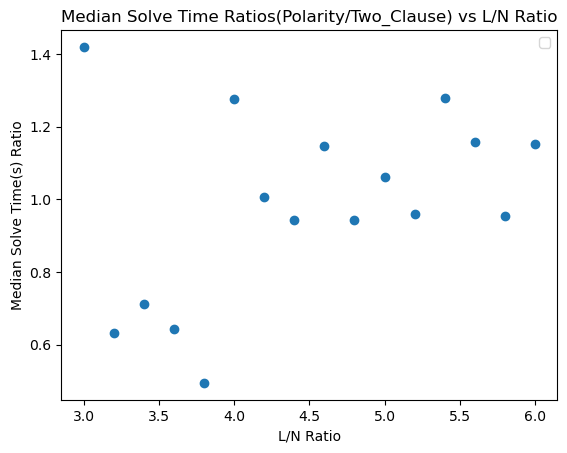

No handles with labels found to put in legend.


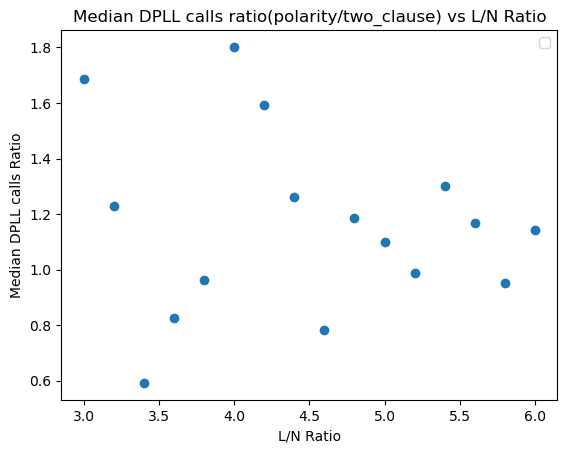

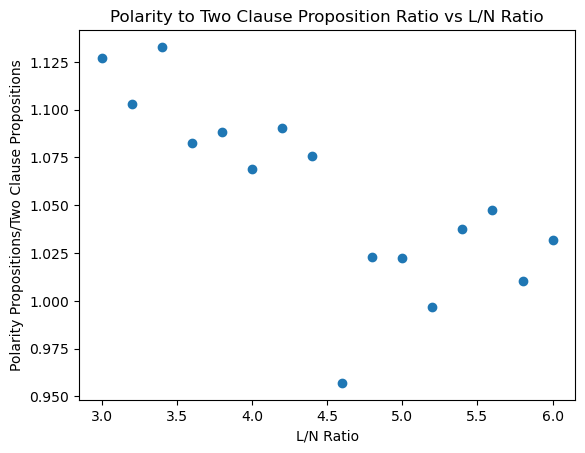

In [88]:
df_two_clause_sample = df_two_clause
df_polarity_sample = df_polarity
df_two_clause_grouped = df_two_clause_sample.groupby('L/N ratio')
df_polarity_grouped = df_polarity_sample.groupby('L/N ratio')
df_two_clause_time = df_two_clause_grouped['solve time'].median()
df_polarity_time = df_polarity_grouped['solve time'].median()
df_two_clause_calls = df_two_clause_grouped['DPLL calls'].median()
df_polarity_calls = df_polarity_grouped['DPLL calls'].median()
df_two_clause_props = df_two_clause_grouped['propositions'].mean()
df_polarity_props = df_polarity_grouped['propositions'].mean()
LN_ratios = []
prop_ratio = []
calls_two_clause = []
calls_polarity = []
time_two_clause = []
time_polarity = []
for i in range(16):
    LN_ratio = i*0.2 + 3
    LN_ratios.append(LN_ratio)
    calls_two_clause.append(df_two_clause_calls[LN_ratio])
    calls_polarity.append(df_polarity_calls[LN_ratio])
    time_two_clause.append(df_two_clause_time[LN_ratio])
    time_polarity.append(df_polarity_time[LN_ratio])
    prop_ratio.append(df_polarity_props[LN_ratio]/df_two_clause_props[LN_ratio])
plt.scatter(LN_ratios,np.array(time_polarity)/np.array(time_two_clause))
plt.legend()
plt.xlabel("L/N Ratio")
plt.ylabel("Median Solve Time(s) Ratio")
plt.title("Median Solve Time Ratios(Polarity/Two_Clause) vs L/N Ratio")
plt.show()
plt.scatter(LN_ratios,np.array(calls_polarity)/np.array(calls_two_clause))
plt.legend()
plt.xlabel("L/N Ratio")
plt.ylabel("Median DPLL calls Ratio")
plt.title("Median DPLL calls ratio(polarity/two_clause) vs L/N Ratio")
plt.show()
plt.xlabel("L/N Ratio")
plt.ylabel("Polarity Propositions/Two Clause Propositions")
plt.title("Polarity to Two Clause Proposition Ratio vs L/N Ratio")
plt.scatter(LN_ratios,prop_ratio)
plt.show()
